In [1]:
# importing the libraries

# torch is a machine learning library, pdb is a debugging tool
import torch, pdb

# it holds the training data as the data is getting iterated through the model
from torch.utils.data import DataLoader

# to build deep learning architecture
from torch import nn

# transform the training data
from torchvision import transforms

# to make a grid of images for evaluation
from torchvision.utils import make_grid

# progress bar creation
from tqdm.auto import tqdm

# data visualization
import matplotlib.pyplot as plt

In [2]:
# importing the dataset

from torchvision.datasets import MNIST

In [3]:
# visualization function

def show(tensor, Img_channel=1, size=(28,28), num_of_images=16):

    # original tensor = 128 x 764
    data = tensor.detach().cpu().view(-1, Img_channel, *size)
    # after the above process = 128 x 1 x 28 x 28

    # now making the grid
    # taking first 16 images to grid and with 4 rows
    # size of the single image = 1 x 28 x 28
    # for matplotlib we must have width , height and channel hece permute is used
    grid = make_grid(data[:num_of_images], nrow=4).permute(1,2,0)
    # after permute(1,2,0) = 28 x 28 x 1

    # to display the images
    plt.imshow(grid)
    plt.show()

In [4]:
# hyperparamaters and main parameters

# iterative process count
epochs = 500

# steps at which the iteration starts
current_steps = 0

# verbose or information to be displayed at which iterative steps
information_of_steps = 300

# loss function mean value
mean_generator_loss = 0
mean_discriminator_loss = 0

# dimension to lowest gradient
latent_space_dim = 64

# how slow the data must be learned according to the optimization
learning_rate = 0.0001

# output of the nn is logits and apply sigmoid function and calculate BCE
loss_func = nn.BCEWithLogitsLoss()
# loss_func = nn.BCELoss()

# how many images can be processed
batch_size = 128

# device
device = 'cuda'

# data loader structure to hold the training data
dataloader = DataLoader(MNIST(".", download= True, transform = transforms.ToTensor()), shuffle = True, batch_size = batch_size)
# . is the specification to store the data in the root folder
# downloading the data as tensor converted
# number of steps = 60000 / 128 i.e., total images divided by the batch_size

100%|██████████| 9912422/9912422 [00:00<00:00, 76570635.77it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 77058329.40it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31553910.29it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13946214.33it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [8]:
# declare the model

# Generator model setup
def genBlock(input_size, output_size):

    # sequential model
    return nn.Sequential(

        # linear layer to load and train the data
        nn.Linear(input_size, output_size),

        # normalizing the data
        nn.BatchNorm1d(output_size),

        # non-linearity to learn More
        nn.ReLU(inplace=True)
    )

# generator class
class Generator(nn.Module):

    # init function
    def __init__(self, latent_space_dim = 64, Output_Image_dim = 784, hidden_layer_dim=128):

        # super keyword to get the functions from nn.Module
        super().__init__()

        # generator function to create sequential model
        self.gen = nn.Sequential(

            # input of latent_space dimension and output of hidden_layer_dimension
            # 64 x 128
            genBlock(latent_space_dim, hidden_layer_dim),

            # 128 x 256
            genBlock(hidden_layer_dim, hidden_layer_dim*2),

            # 256 x 512
            genBlock(hidden_layer_dim*2, hidden_layer_dim*4),

            # 512 x 1024
            genBlock(hidden_layer_dim*4, hidden_layer_dim*8),

            # linear layer for generating the image
            # 1024 x 784
            nn.Linear(hidden_layer_dim*8, Output_Image_dim),

            # setting the values between 0 and 1
            nn.Sigmoid()
        )

    def forward(self, noise):
            return self.gen(noise)

# creating the random number and feeding into the network
def gen_noise(number, latent_space_dim):
    return torch.randn(number, latent_space_dim)

In [9]:
# discriminator model creation

# discriminator architecture block
def disBlock(input_size, output_size):
    return nn.Sequential(
        # linear layer
        nn.Linear(input_size, output_size),

        # it does not have dying RELU
        nn.LeakyReLU(0.2)
    )

class Discriminator(nn.Module):

    def __init__(self, Image_dim = 784, hidden_layer_dim = 256):
        super().__init__()
        self.disc = nn.Sequential(
            # 784 x 1024
            disBlock(Image_dim, hidden_layer_dim*4),

            # 1024 x 512
            disBlock(hidden_layer_dim*4, hidden_layer_dim*2),

            # 512 x 256
            disBlock(hidden_layer_dim*2, hidden_layer_dim),

            # linear Layer 256 x 1
            nn.Linear(hidden_layer_dim, 1)
        )

    def forward(self, image):
            return self.disc(image)

In [10]:
# creating the generator and the discriminator

# generator
gen = Generator(latent_space_dim)

# optimizer for the generator
gen_opt = torch.optim.Adam(gen.parameters(), lr = learning_rate)

# discriminator
disc = Discriminator()

# optimizer for the discriminator
disc_opt = torch.optim.Adam(disc.parameters(), lr = learning_rate)

In [11]:
# displaying the generator layer
print(gen)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [12]:
# displaying the generator layer
print(disc)

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [13]:
# data loader

x,y = next(iter(dataloader))

print(x.shape, y.shape)
print(y[:10])

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([7, 5, 4, 7, 2, 6, 7, 1, 7, 2])


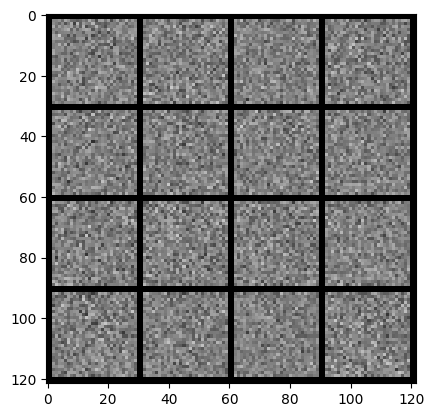

In [14]:
# visualization

noise = gen_noise(batch_size, latent_space_dim)
fake_images = gen(noise)
show(fake_images)

In [15]:
# calculating the loss

# 1. Generator loss
def  calc_gen_loss(loss_func, gen, disc, number, latent_space_dim):

  # 1. generate the noise vector
  noise = gen_noise(number, latent_space_dim)

  # fake images are generated with the help of the noise vector specified
  fake_images = gen(noise)

  # feeding the noise image into the discriminator
  pred = disc(fake_images)

  # target for generator is to compare it with 1 complately true
  targets=torch.ones_like(pred)

  # calculation of difference
  gen_loss = loss_func(pred, targets)
  return gen_loss

# 2. discriminator loss
def calc_disc_loss(loss_func, gen, disc, number, real, latent_space_dim):

  # noise generation
  noise = gen_noise(number, latent_space_dim)
  fake_images = gen(noise)

  # fake image loss calculation
  disc_fake = disc(fake_images.detach())
  disc_fake_targets = torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake, disc_fake_targets)

  # real image noise calculation
  disc_real = disc(real)
  disc_real_targets = torch.ones_like(disc_real)
  disc_real_loss = loss_func(disc_real, disc_real_targets)

  # mean of the losses
  disc_loss = (disc_fake_loss + disc_real_loss) / 2
  return disc_loss

  0%|          | 0/469 [00:00<?, ?it/s]

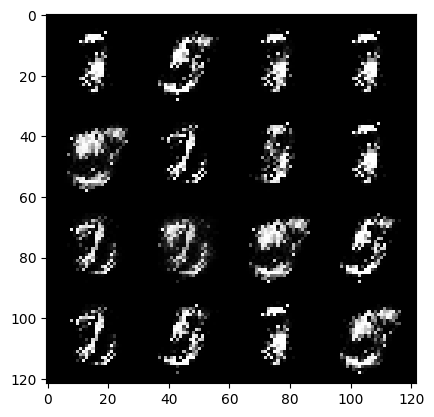

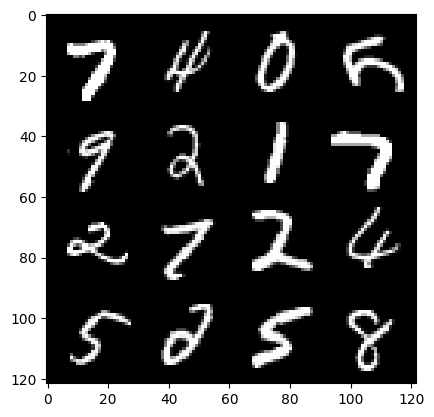

Epoch: 0, step: 300, Generator Loss: 0.02098633925120036, Discriminator Loss: 0.0001614813506603241


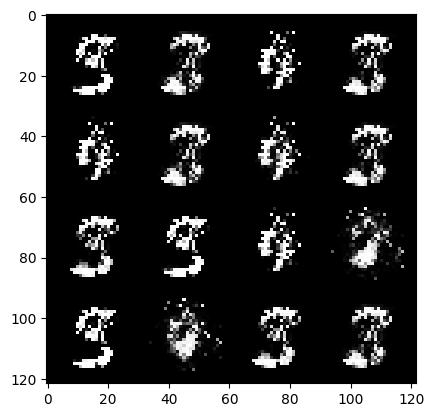

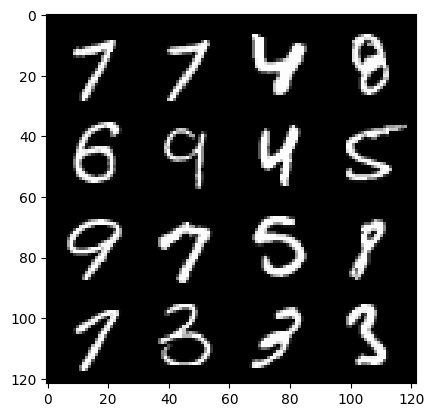

Epoch: 0, step: 600, Generator Loss: 0.023962562878926594, Discriminator Loss: 5.93432846168677e-05


  0%|          | 0/469 [00:00<?, ?it/s]

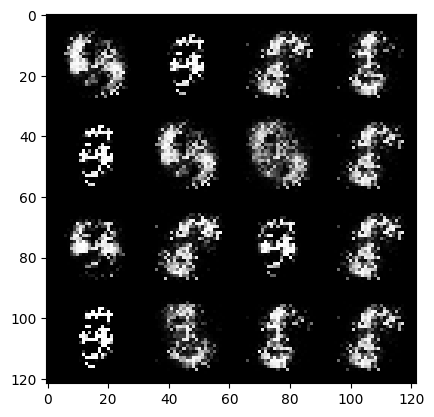

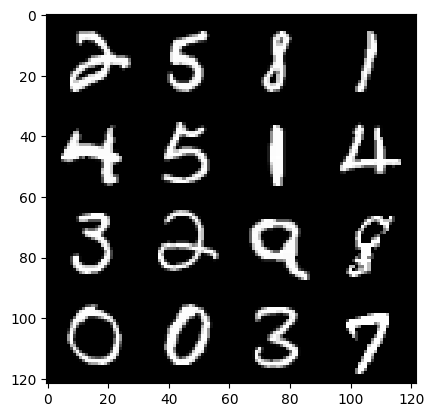

Epoch: 1, step: 900, Generator Loss: 0.01866923491160075, Discriminator Loss: 0.00016315640260775884


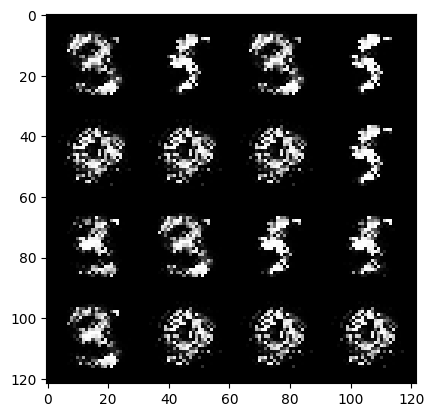

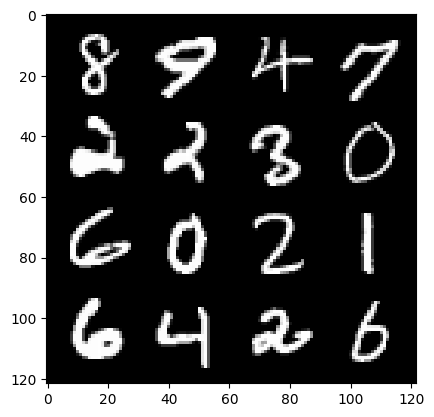

Epoch: 1, step: 1200, Generator Loss: 0.02155350685119629, Discriminator Loss: 7.432921479145686e-05


  0%|          | 0/469 [00:00<?, ?it/s]

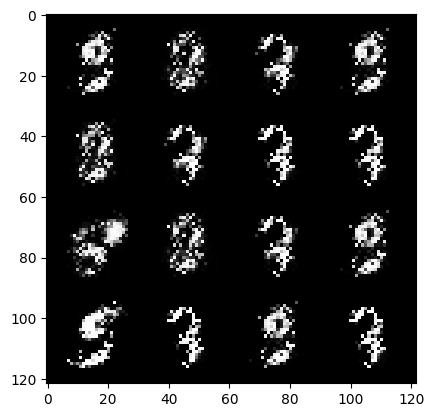

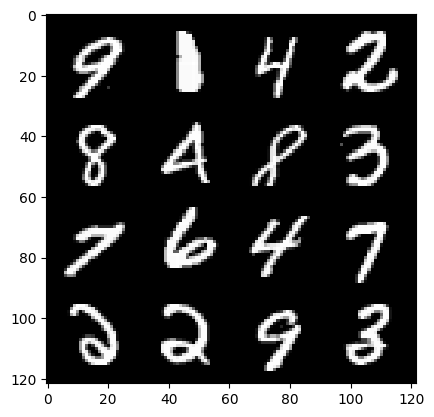

Epoch: 2, step: 1500, Generator Loss: 0.021484198570251464, Discriminator Loss: 2.5570023184021313e-05


  0%|          | 0/469 [00:00<?, ?it/s]

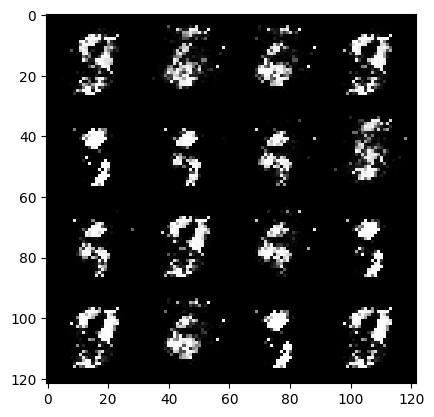

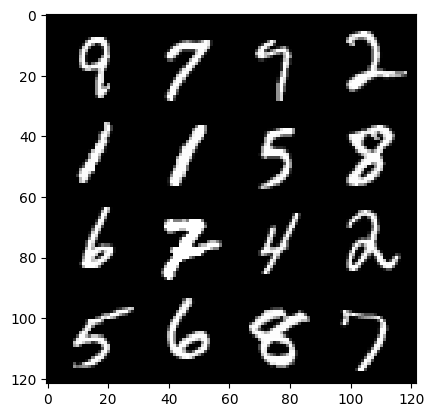

Epoch: 3, step: 1800, Generator Loss: 0.0229427178700765, Discriminator Loss: 4.605862001578013e-05


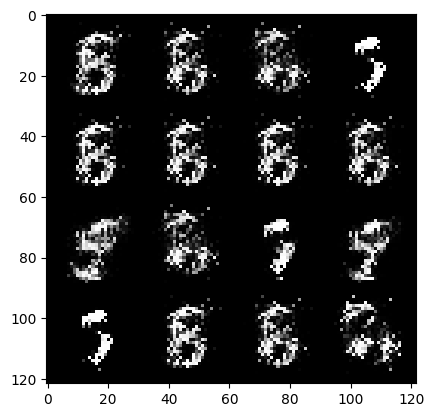

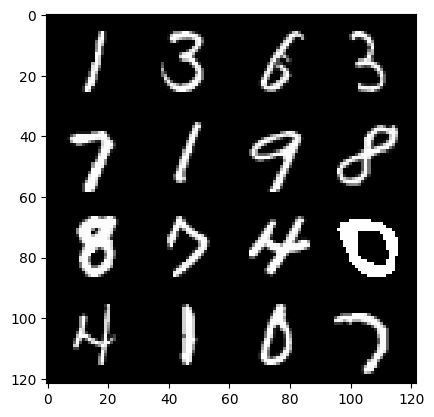

Epoch: 3, step: 2100, Generator Loss: 0.022375466028849284, Discriminator Loss: 3.545590986808141e-05


  0%|          | 0/469 [00:00<?, ?it/s]

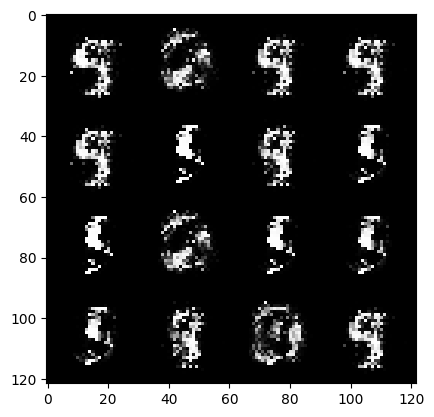

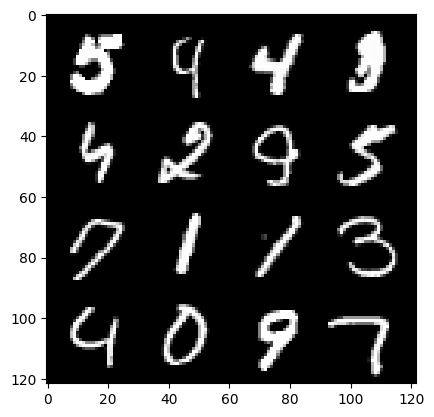

Epoch: 4, step: 2400, Generator Loss: 0.018663074175516766, Discriminator Loss: 5.615413188934326e-05


  0%|          | 0/469 [00:00<?, ?it/s]

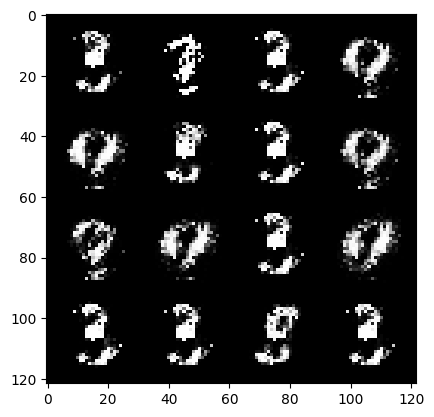

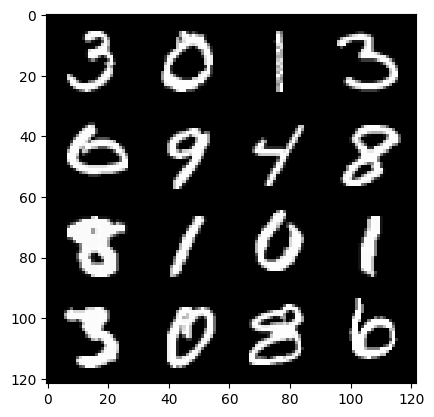

Epoch: 5, step: 2700, Generator Loss: 0.020508219401041666, Discriminator Loss: 4.688371283312639e-05


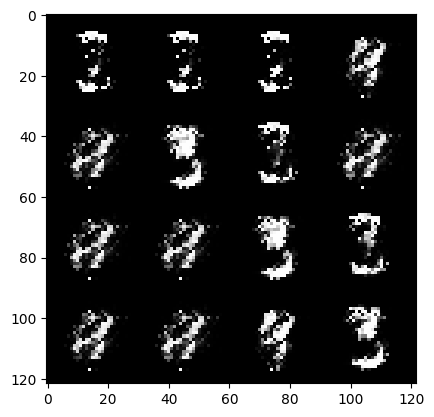

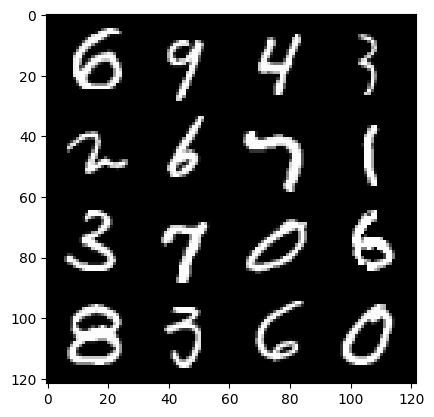

Epoch: 5, step: 3000, Generator Loss: 0.023291076024373372, Discriminator Loss: 6.248349323868751e-05


  0%|          | 0/469 [00:00<?, ?it/s]

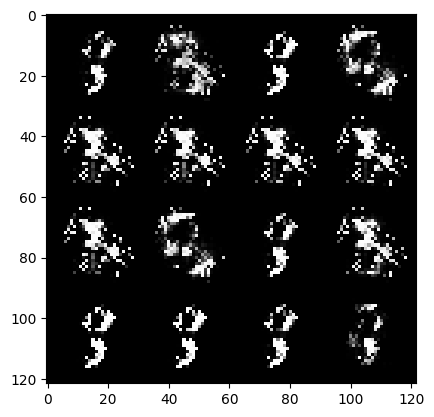

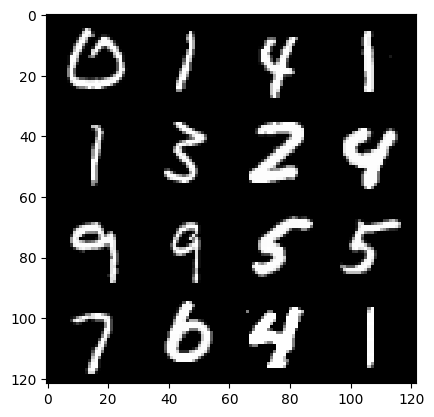

Epoch: 6, step: 3300, Generator Loss: 0.02246766726175944, Discriminator Loss: 4.0162637208898866e-05


  0%|          | 0/469 [00:00<?, ?it/s]

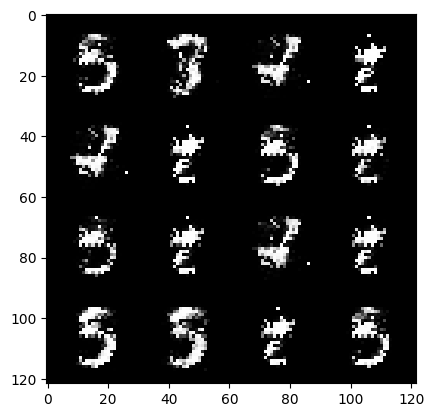

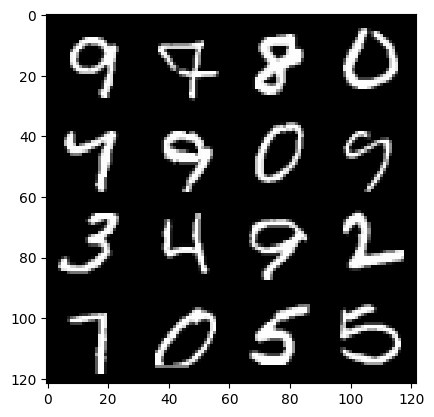

Epoch: 7, step: 3600, Generator Loss: 0.03068306605021159, Discriminator Loss: 6.16225724418958e-05


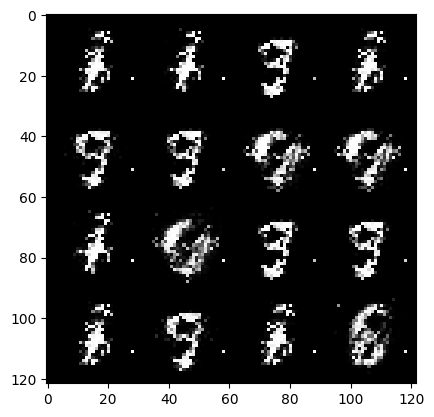

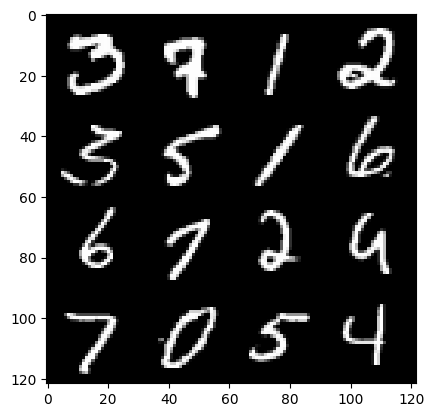

Epoch: 7, step: 3900, Generator Loss: 0.021841309865315756, Discriminator Loss: 8.420420189698537e-05


  0%|          | 0/469 [00:00<?, ?it/s]

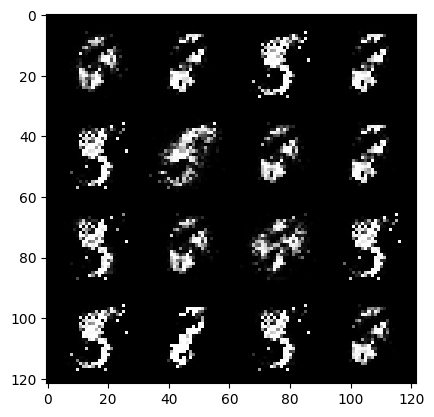

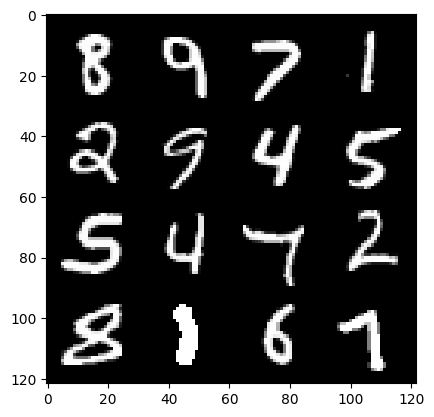

Epoch: 8, step: 4200, Generator Loss: 0.02101331075032552, Discriminator Loss: 8.144557476043702e-05


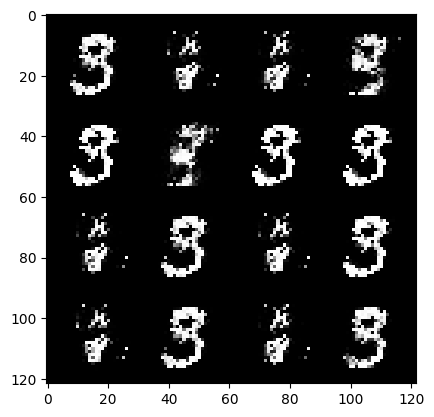

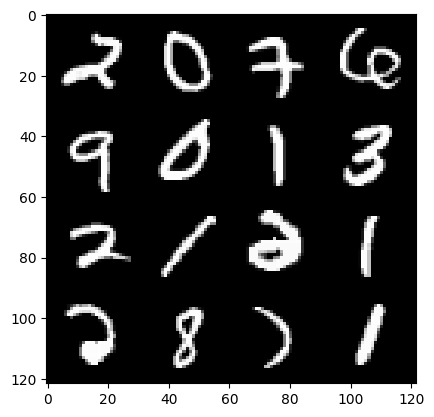

Epoch: 8, step: 4500, Generator Loss: 0.0246695073445638, Discriminator Loss: 8.34037084132433e-06


  0%|          | 0/469 [00:00<?, ?it/s]

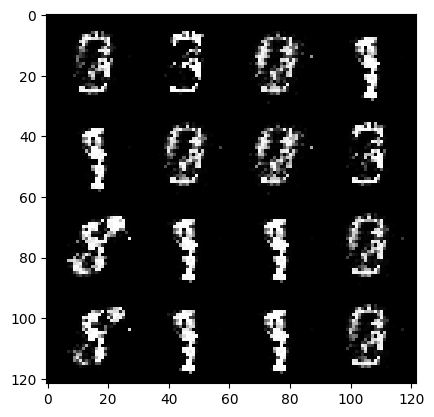

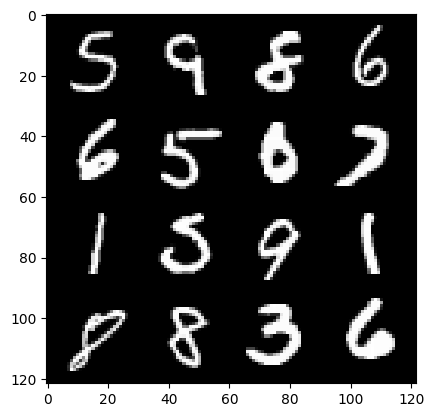

Epoch: 9, step: 4800, Generator Loss: 0.02191532770792643, Discriminator Loss: 0.00015492592006921768


  0%|          | 0/469 [00:00<?, ?it/s]

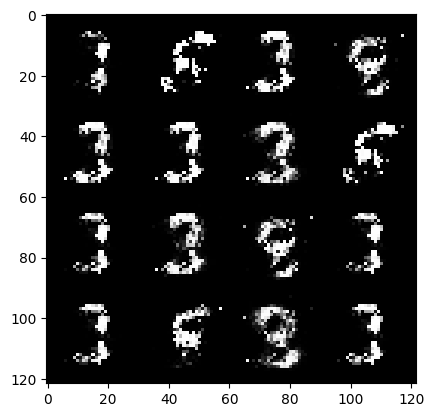

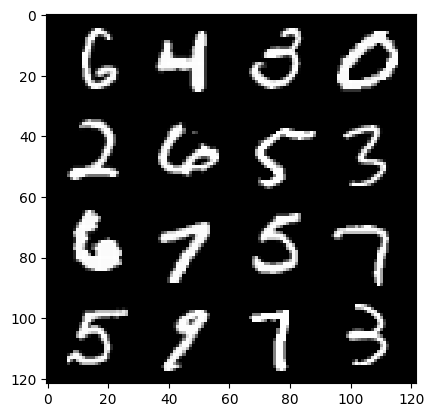

Epoch: 10, step: 5100, Generator Loss: 0.025092743237813315, Discriminator Loss: 9.488947689533234e-05


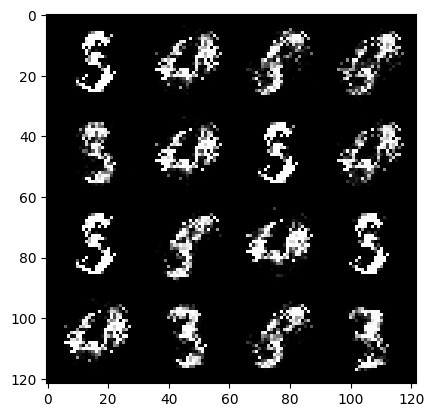

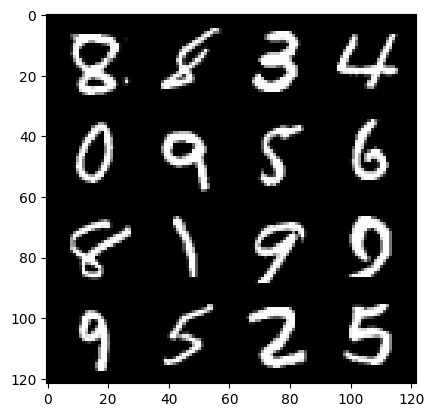

Epoch: 10, step: 5400, Generator Loss: 0.024394655227661134, Discriminator Loss: 3.3710698286692304e-05


  0%|          | 0/469 [00:00<?, ?it/s]

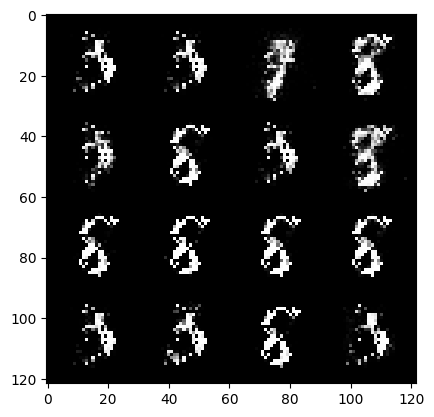

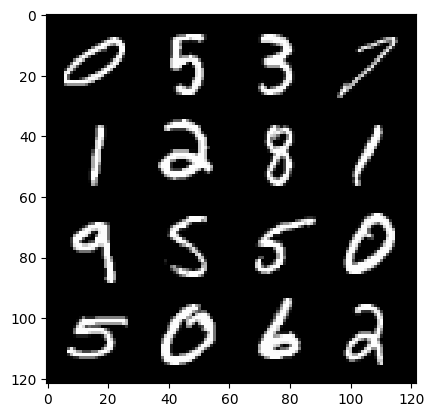

Epoch: 11, step: 5700, Generator Loss: 0.022028854688008626, Discriminator Loss: 4.326671361923218e-05


  0%|          | 0/469 [00:00<?, ?it/s]

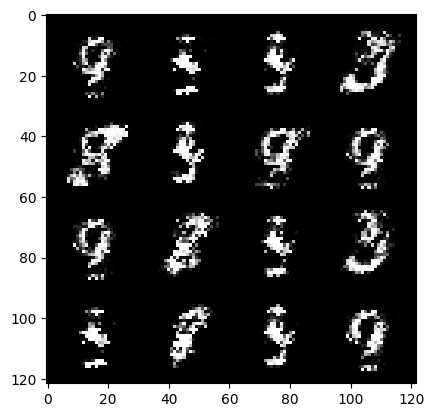

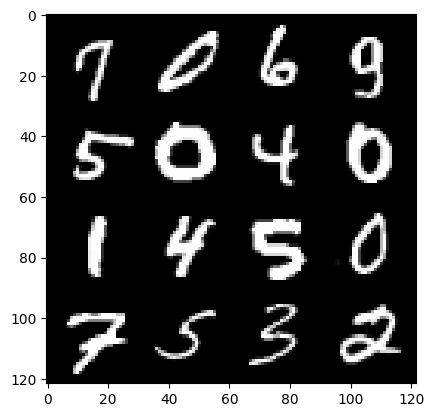

Epoch: 12, step: 6000, Generator Loss: 0.02024919827779134, Discriminator Loss: 0.00016765293975671132


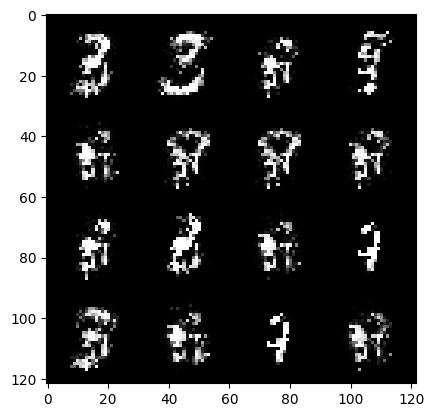

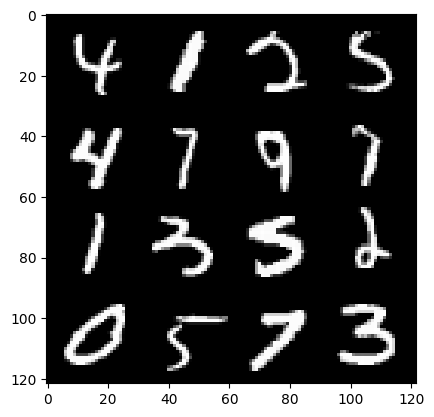

Epoch: 12, step: 6300, Generator Loss: 0.021154508590698243, Discriminator Loss: 1.672373153269291e-05


  0%|          | 0/469 [00:00<?, ?it/s]

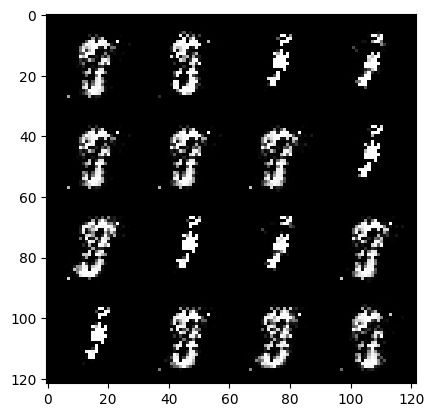

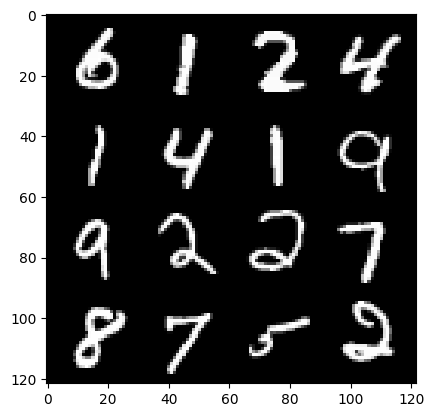

Epoch: 13, step: 6600, Generator Loss: 0.024106138547261555, Discriminator Loss: 5.0719905023773514e-05


  0%|          | 0/469 [00:00<?, ?it/s]

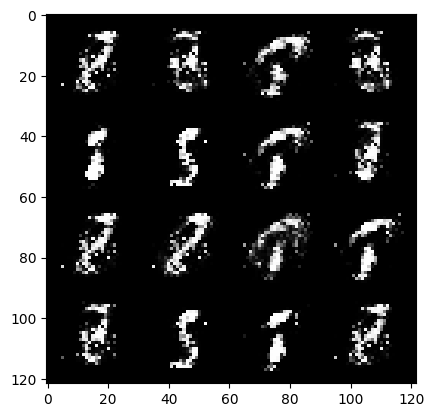

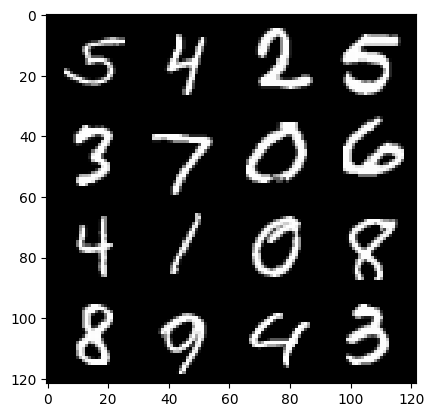

Epoch: 14, step: 6900, Generator Loss: 0.021443285942077638, Discriminator Loss: 4.0701981633901594e-05


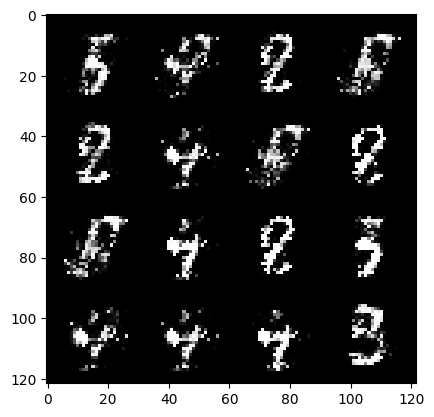

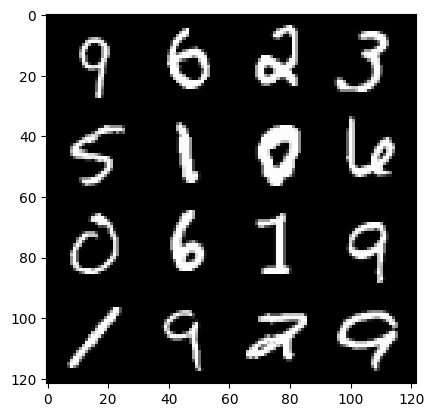

Epoch: 14, step: 7200, Generator Loss: 0.01986642519632975, Discriminator Loss: 2.456916496157646e-05


  0%|          | 0/469 [00:00<?, ?it/s]

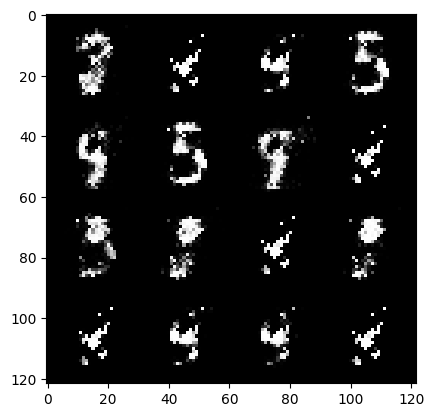

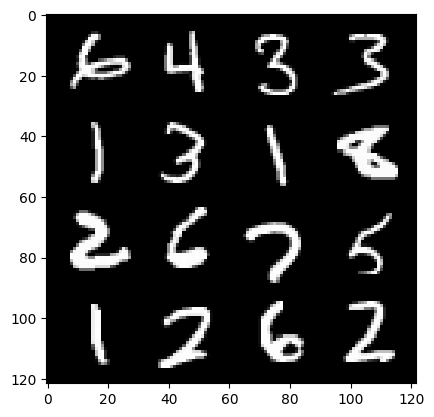

Epoch: 15, step: 7500, Generator Loss: 0.020722963015238443, Discriminator Loss: 7.803324609994888e-05


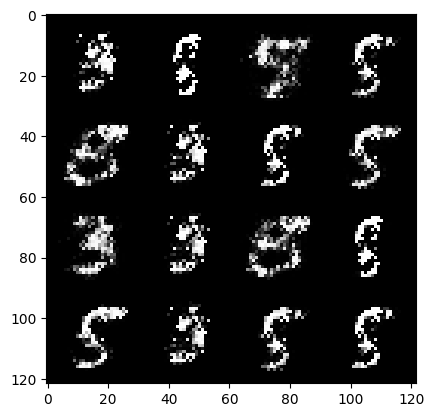

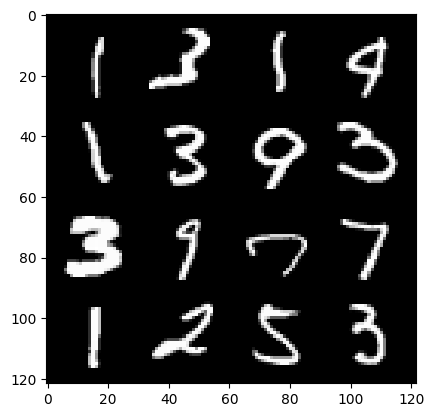

Epoch: 15, step: 7800, Generator Loss: 0.023380268414815268, Discriminator Loss: 9.78625441590945e-05


  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
# main training loop

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    # discriminator training

    # setting the optimizer gradient to zero
    disc_opt.zero_grad()
    # setting the batch size
    current_bs = len(real) # 128 x 1 x 28 x 28
    # reshaping
    real = real.view(current_bs, -1)
    # calculating the loss
    disc_loss = calc_disc_loss(loss_func, gen, disc, current_bs, real, latent_space_dim)
    # feedback system
    disc_loss.backward(retain_graph=True)
    # tweak and update the parameters of the discriminator
    disc_opt.step()

    # generator training

    # optimizer to be zero
    gen_opt.zero_grad()
    # calculate the loss
    gen_loss = calc_gen_loss(loss_func, gen, disc, current_bs, latent_space_dim)
    # feedback system
    gen_loss.backward(retain_graph = True)
    # tweak and update the parameters
    gen_opt.step()

    # visualization
    mean_discriminator_loss = disc_loss.item() / information_of_steps
    mean_generator_loss = gen_loss.item() / information_of_steps

    # when to show the information
    if current_steps % information_of_steps == 0 and current_steps > 0:
      fake_noise = gen_noise(current_bs, latent_space_dim)
      fake = gen(fake_noise)

      show(fake)
      show(real)
      print("Epoch: {0}, step: {1}, Generator Loss: {2}, Discriminator Loss: {3}".format(epoch, current_steps, mean_generator_loss, mean_discriminator_loss))

      mean_discriminator_loss, mean_generator_loss = 0,0

    current_steps += 1